In [23]:
import numpy as np
import os
from astropy.io import fits
from astropy import units as u
from ccdproc import (
    CCDData,
    combine,
    subtract_bias,
    subtract_dark,
    flat_correct,
    )
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [24]:
in_path = '/Users/u5500483/Downloads/DATA_MAC/CMOS/20231212/'
out_path = '/Users/u5500483/Downloads/DATA_MAC/CMOS/calibration_images/'

In [25]:
os.chdir(in_path)

Combining 20 bias images


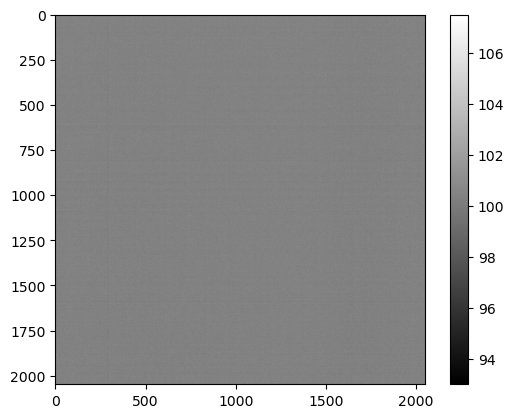

In [26]:
if os.path.exists(out_path + 'master_bias.fits'):
    print('Master bias already exists')
    pass
else:
    bias_list = [f for f in glob.glob(in_path + 'bias*.fits') if 'HDR' in fits.getheader(f)['READMODE']]
    bias_list = bias_list[:20]
    print('Combining {} bias images'.format(len(bias_list)))

    ccd_list = []
    for f in bias_list:
        ccd = CCDData.read(f, unit='adu')
        ccd_list.append(ccd)

# Combine the bias images
    master_bias = combine(ccd_list, method='median')
    # master_bias.data = master_bias.data.astype('int16')
    master_bias.write(out_path + 'master_bias.fits', overwrite=True)
    plt.imshow(master_bias, cmap='gray')
    plt.colorbar()
    plt.show()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Combining 20 dark images


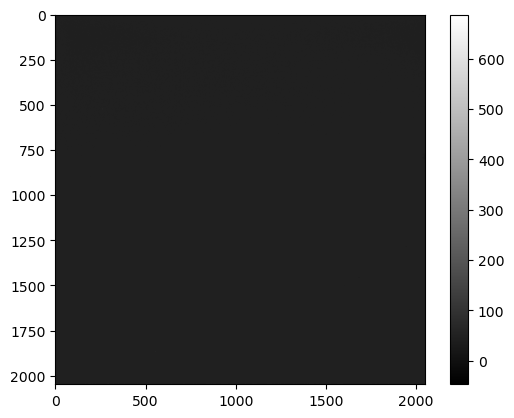

In [27]:
master_bias = CCDData.read(out_path + 'master_bias.fits', unit='adu')
if os.path.exists(out_path + 'master_dark.fits'):
    print('Master dark already exists')
    pass
else:
    dark_list = [f for f in glob.glob(in_path + 'dark*.fits') if 'HDR' in fits.getheader(f)['READMODE']]
    dark_list = dark_list[:20]
    print('Combining {} dark images'.format(len(dark_list)))

    ccd_list = []
    for f in dark_list:
        ccd = CCDData.read(f, unit='adu')
        ccd = subtract_bias(ccd, master_bias)
        ccd_list.append(ccd)
        
    master_dark = combine(ccd_list, method='median')
    # master_dark.data = master_dark.data.astype('int16')
    master_dark.write(out_path + 'master_dark.fits', overwrite=True)
    plt.imshow(master_dark, cmap='gray')
    plt.colorbar()
    plt.show()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Combining 20 flat images


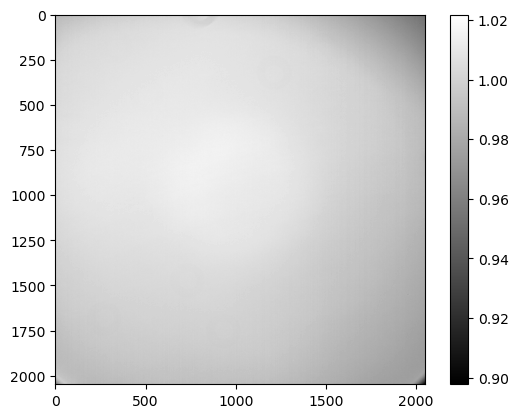

In [28]:
master_bias = CCDData.read(out_path + 'master_bias.fits', unit='adu')
master_dark = CCDData.read(out_path + 'master_dark.fits', unit='adu')

if os.path.exists(out_path + 'master_flat.fits'):
    print('Master flat already exists')
else:
    exptime_keyword = 'EXPTIME'
    dark_exp = 10
    flat_list = [f for f in glob.glob(in_path + 'evening*.fits') if 'HDR' in fits.getheader(f)['READMODE']]
    flat_list = flat_list[:20]
    print('Combining {} flat images'.format(len(flat_list)))

    flat_list_combined = []
    for f in flat_list:
            with fits.open(f) as fitsfile:
                data_exp = int(fits.getheader(f)[exptime_keyword])
                ccd = CCDData.read(f, unit=u.adu)
                ccd = subtract_bias(ccd, master_bias)
                ccd = subtract_dark(ccd, master_dark,
                                    scale=True,
                                    dark_exposure=dark_exp * u.second,
                                    data_exposure=data_exp * u.second)
                ccd.data = ccd.data / np.ma.average(ccd.data)
                flat_list_combined.append(ccd)

    master_flat = combine(flat_list_combined, method='median')
    master_flat.write(out_path + 'master_flat.fits', overwrite=True)

    # Plotting outside the loop
    plt.imshow(master_flat, cmap='gray')
    plt.colorbar()
    plt.show()


In [30]:
data_path = '/Users/u5500483/Downloads/DATA_MAC/CMOS/TOI-00451/'  # Replace with your actual output path
out_path = '/Users/u5500483/Downloads/DATA_MAC/CMOS/calibration_images/'

master_bias = CCDData.read(out_path + 'master_bias.fits', unit='adu')
master_dark = CCDData.read(out_path + 'master_dark.fits', unit='adu')
master_flat = CCDData.read(out_path + 'master_flat.fits', unit='adu')

r_files = glob.glob(data_path + '*TOI*_r.fits')

if r_files:
    print('Images have been calibrated from bias, dark, and flat')
else:
    dark_exp = 10
    exptime_keyword = 'EXPTIME'
    science_list = [f for f in glob.glob(data_path + '*TOI*.fits')]
    for f in science_list:
        ccd = CCDData.read(f, unit=u.adu)
        ccd = subtract_bias(ccd, master_bias)

        with fits.open(f) as fitsfile:
            # collect/correct some header values
            hdr = fitsfile[0].header
            data_exp = int(hdr[exptime_keyword])

        ccd = subtract_dark(ccd, master_dark,
                            scale=True,
                            dark_exposure=dark_exp*u.second,
                            data_exposure=data_exp*u.second)
        ccd = flat_correct(ccd, master_flat)
        ccd.data = ccd.data.astype('int16')
        new_filename = '{}_r.fits'.format(f.split('.fits')[0])
        fits.writeto(new_filename, ccd.data, hdr, overwrite=True)
    print('Science images have been calibrated from bias, dark, and flat')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Science images have been calibrated from bias, dark, and flat
